<a href="https://colab.research.google.com/github/ABHI2410/ComputerVision/blob/main/PA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 6367 Programming Assignment 2 (P2)

## Summer 2023

## Due: 11:59pm Central Time, Friday, July 21, 2023

### Task 1 (50 points)

Implement Hough transform from scratch to detect circles in the image. Refer to this wiki page for pseudocode(https://en.wikipedia.org/wiki/Circle_Hough_Transform). Superimpose detected circles on the original image.

Note: You shouldn't use cv2.HoughCircles() or any other library fuctions to detect the circles.

<img src = Images/chessboard.jpg>

In [166]:
import cv2
import numpy as np
from math import cos, sin, pi
from matplotlib import pyplot as plt
import scipy
from google.colab.patches import cv2_imshow
from collections import defaultdict
from tqdm import tqdm
from itertools import product
from IPython.display import clear_output

In [172]:
def non_max_suppression(edges, circle_centers, circle_radii, distance_threshold):
    # Zip the two lists together and sort based on list1
    sorted_lists = sorted(zip(circle_radii, circle_centers),reverse=False)

    # Unzip the sorted lists
    circle_radii, circle_centers = zip(*sorted_lists)

    selected_circles = []
    selected_radius = []
    for current_circle, radius in tqdm(zip(circle_centers, circle_radii), total= len(circle_radii)):
        x1, y1= current_circle
        r1 = radius
        suppress = False

        for selected_circle, rad in zip(selected_circles,selected_radius):
            x2, y2 = selected_circle
            r2 = rad
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

            if distance < distance_threshold:
                print(edges[x2+r2,y2],edges[x2-r2,y2],edges[x2,y2+r2],edges[x2,y2-r2])
                if edges[x2+r2,y2] == 255 and edges[x2-r2,y2] == 255 and edges[x2,y2+r2] == 255 and edges[x2,y2-r2] ==255 :
                    suppress = True
                    break

        if not suppress:
            selected_circles.append((x1,y1))
            selected_radius.append(r1)

    return selected_circles, selected_radius


In [173]:
def calculate_r_values(args):
    r, t = args
    return (r, int(r * math.cos(math.pi * t / 180)), int(r * math.sin(math.pi * t / 180)))

In [174]:
def hough_transform_circle(edges, min_radius, max_radius, threshold):
    # Step 1: Edge detection using Canny
    height, width = edges.shape

    # Step 2: Accumulator
    accumulator = np.zeros((height, width, max_radius - min_radius + 1), dtype=np.uint16)
    r_value_for_circle = []
    # Using map and itertools.product to calculate r_value_for_circle
    r_values = map(calculate_r_values, product(range(min_radius, max_radius + 1), range(360)))

    # Convert map result to a list (optional)
    r_value_for_circle = list(r_values)

    # Step 3: Voting
    y_idxs, x_idxs = np.nonzero(edges)
    detected_circles = []
    for i in tqdm(range(len(x_idxs))):
        x = x_idxs[i]
        y = y_idxs[i]
        for r,xcos,ysin in r_value_for_circle:
                a = x - xcos
                b = y - ysin
                if 0 <= int(a) < width and 0 <= int(b) < height:
                    accumulator[int(b), int(a), r - min_radius] += 1

    # Step 4: Find the circles
    circles = np.argwhere(accumulator >= threshold)
    circle_radii = circles[:, 2] + min_radius

    return circle_centers, circle_radii

100%|██████████| 8/8 [00:00<00:00, 2743.84it/s]


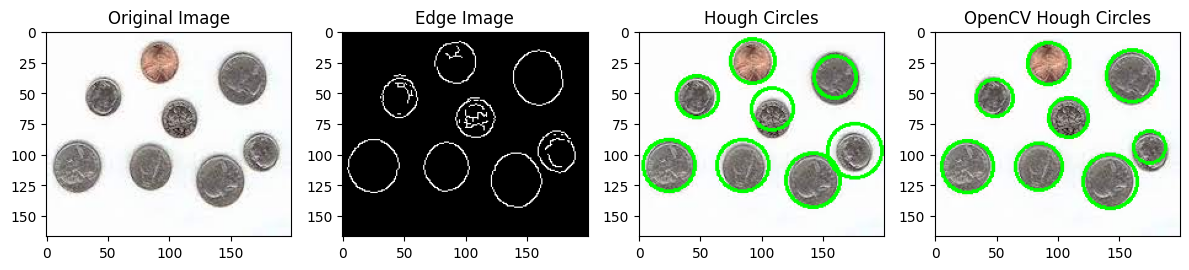

In [175]:
originalimage = cv2.imread("./Images/circles.jpeg")
originalimage = cv2.cvtColor(originalimage, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(originalimage, cv2.COLOR_RGB2GRAY)
image = cv2.GaussianBlur(image, (5, 5), 3)
edges = cv2.Canny(image, 50, 150)
# Set the parameters for circle detection
min_radius = 10
max_radius = 100
threshold = 150

# Apply Hough Transform for circle detection
circle_centers, circle_radii = hough_transform_circle(edges, min_radius, max_radius, threshold)
circle_centers, circle_radii = non_max_suppression(edges, circle_centers, circle_radii, 20)
# Superimpose detected circles on the original image
color_image = originalimage.copy()
for center, radius in tqdm(zip(circle_centers, circle_radii), total = len(circle_radii)):
    center = tuple(center)
    cv2.circle(color_image, center, radius, (0, 255, 0), 2)  # Draw a green circle

# Opencv Hough circles

color_image2 = originalimage.copy()
detected_circles = cv2.HoughCircles(image,
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 30, minRadius = 10, maxRadius = 100)

# Draw circles that are detected.
if detected_circles is not None:

    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))

    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]

        # Draw the circumference of the circle.
        cv2.circle(color_image2, (a, b), r, (0, 255, 0), 2)

# Display the original image with detected circles
# Create a 1x3 subplot
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
# Display the original image
axs[0].imshow(originalimage, cmap='gray')
axs[0].set_title('Original Image')
# Display the edge image
axs[1].imshow(edges, cmap='gray')
axs[1].set_title('Edge Image')
# Display the Hough Circles
axs[2].imshow(color_image, cmap='gray')
axs[2].set_title('Hough Circles')
# Display the OpenCV Hough Circles
axs[3].imshow(color_image2, cmap='gray')
axs[3].set_title('OpenCV Hough Circles')
# Adjust the spacing between subplots
plt.tight_layout()
# Display the plot
plt.show()

### Task 2 (50 points)

Implement Harris corner detector from scratch. The steps are mentioned in Slide 46-47 on your lecture slide "5-Harris-corner-detector.pdf". Mark detected corners on original image.

Note: You shouldn't use cv2.cornerHarris() or any other library functions to detect the corners.

<img src = Images/chessboard.jpg>

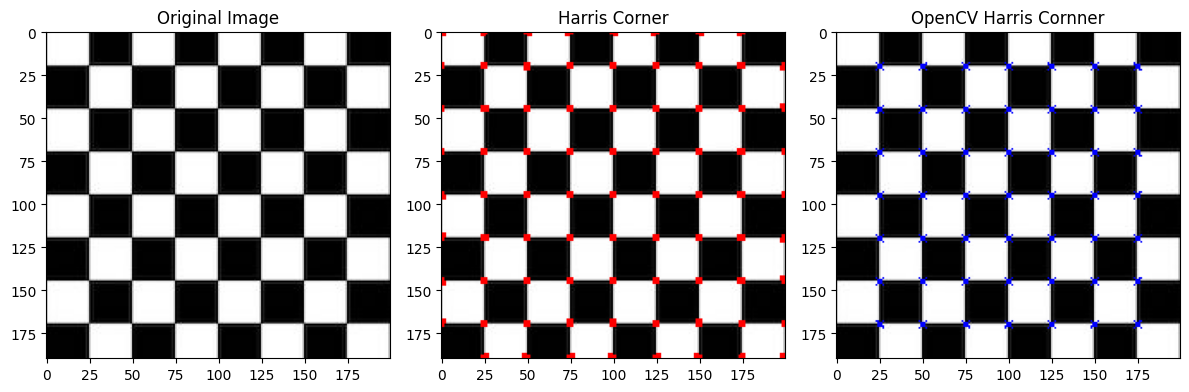

In [165]:
from cv2.gapi import gaussianBlur
img = cv2.imread("./Images/chessboard.jpg")
grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussianBlur = cv2.GaussianBlur(grayscale_image, (5,5), 5)

kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

ix = scipy.signal.convolve2d(gaussianBlur, kernel_x, mode='same')
iy = scipy.signal.convolve2d(gaussianBlur, kernel_y, mode='same')

I_xx = scipy.ndimage.gaussian_filter(ix**2, sigma=1)
I_yy = scipy.ndimage.gaussian_filter(iy**2, sigma=1)
I_xy = scipy.ndimage.gaussian_filter(ix*iy, sigma=1)

determinent =  I_xx * I_yy - (I_xy ** 2)
trace = I_xx + I_yy
h = determinent - 0.05 * trace ** 2

# Draw circles on the image

image2 = img.copy()

h = cv2.erode(h, None)
h = cv2.dilate(h, None)

image2[h > 0.01*h.max()] = [255,0,0]

image3 = img.copy()
operatedImage = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
operatedImage = np.float32(operatedImage)
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07)

image3[dest > 0.01*dest.max()]=[0, 0, 255]


# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Display the Original Image
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
# Display the Harris Conner Image
axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Harris Corner')
# Display the OpenCv Harris Conner Image
axs[2].imshow(image3, cmap='gray')
axs[2].set_title('OpenCV Harris Cornner')
# Adjust the spacing between subplots
plt.tight_layout()
# Display the plot
plt.show()


## Submission Guidelines:

    Submit through Canvas your source code in a single .ipynb file. The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
    Import all the images from the ./Images directory. Your TA will use the same directory name to grade your submission.
    You don't need to attach the image file with your submission.
